In [218]:
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt


In [219]:
data_path = './data/stock_1d.parquet'
data = pd.read_parquet(data_path)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1330238 entries, 0 to 1330237
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Date                   1330238 non-null  datetime64[us]
 1   Open                   1330224 non-null  float64       
 2   High                   1330224 non-null  float64       
 3   Low                    1330224 non-null  float64       
 4   Close                  1330224 non-null  float64       
 5   Adj Close              1330224 non-null  float64       
 6   Volume                 1330224 non-null  float64       
 7   Symbol                 1330238 non-null  object        
 8   Security               1330238 non-null  object        
 9   GICS Sector            1330238 non-null  object        
 10  GICS Sub-Industry      1330238 non-null  object        
 11  Headquarters Location  1330238 non-null  object        
 12  Date added             1302908 no

Date: Date of the data. </br>

Open, High, Low, Close: Prices during the trading day. </br>

Adj Close: Adjusted closing price considering corporate actions, usually better represents actual close. </br>

Volume: Total shares traded. </br>

Symbol: Unique identifier (e.g., stock ticker). </br>

Security: Description of the financial instrument. </br>

GICS Sector, GICS Sub-Industry: Industry classification. </br>

Headquarters Location: Location of the company's headquarters. </br>

Date added: Date the data was recorded. </br>

CIK: (Central Index key) Unique identifier assigned by SEC. </br>

Founded: Founding date or year of the company. </br>

In [234]:
Sym = 'AAPL'
Close = 'Adj Close' 
#write 'Close' or 'Adj Close' to choose
# As far as I have found Close is better for short term and Adj Close is better for long term analysis as it considers actions of the company like dividends and stuff

Sym_data = data[data['Symbol'] == Sym]
Sym_data = Sym_data[Sym_data['Date']< datetime.now()]
Sym_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
115293,2023-11-02,175.520004,177.779999,175.460007,177.570007,177.570007,77334800.0,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
115294,2023-11-03,174.240005,176.820007,173.350006,176.649994,176.649994,79763700.0,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
115295,2023-11-06,176.380005,179.429993,176.210007,179.229996,179.229996,63841300.0,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
115296,2023-11-07,179.179993,182.440002,178.970001,181.820007,181.820007,70530000.0,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
115297,2023-11-08,182.350006,183.449997,181.589996,182.889999,182.889999,49340300.0,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977


In [235]:
#Basic Stats:

summary_stats = Sym_data.describe()

# Extracting Mean, Median, Standard Deviation, and Percentiles
mean_price = summary_stats.loc['mean', Close]
median_price = Sym_data[Close].median()
std_dev_price = summary_stats.loc['std', Close]
percentile_25 = Sym_data[Close].quantile(0.25)
percentile_75 = Sym_data[Close].quantile(0.75)

# Displaying the Summary Statistics
print("Mean Price: {:.2f}".format(mean_price))
print("Median Price: {:.2f}".format(median_price))
print("Standard Deviation: {:.2f}".format(std_dev_price))
print("25th Percentile: {:.2f}".format(percentile_25))
print("75th Percentile: {:.2f}".format(percentile_75))

Mean Price: 68.93
Median Price: 41.65
Standard Deviation: 55.63
25th Percentile: 25.15
75th Percentile: 125.10


In [236]:
#Simple Moving Averages (SMA) 
Sym_data['SMA_50'] = Sym_data[Close].rolling(window=50).mean()
Sym_data['SMA_200'] = Sym_data[Close].rolling(window=200).mean()

#Exponential Moving Averages (EMA)
Sym_data['EMA_12'] = Sym_data[Close].ewm(span=12, adjust=False).mean()
Sym_data['EMA_26'] = Sym_data[Close].ewm(span=26, adjust=False).mean()

#Relative Strength Index (RSI)
delta = Sym_data[Close].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()

rs = average_gain / average_loss
Sym_data['RSI'] = 100 - (100 / (1 + rs))


#Moving Average Convergance Divergence (MACD)
Sym_data['MACD'] = Sym_data['EMA_12'] - Sym_data['EMA_26']
Sym_data['Signal_Line'] = Sym_data['MACD'].ewm(span=9, adjust=False).mean()
cross_above = (Sym_data['MACD'] > Sym_data['Signal_Line']) & (Sym_data['MACD'].shift(1) <= Sym_data['Signal_Line'].shift(1))
cross_below = (Sym_data['MACD'] < Sym_data['Signal_Line']) & (Sym_data['MACD'].shift(1) >= Sym_data['Signal_Line'].shift(1))


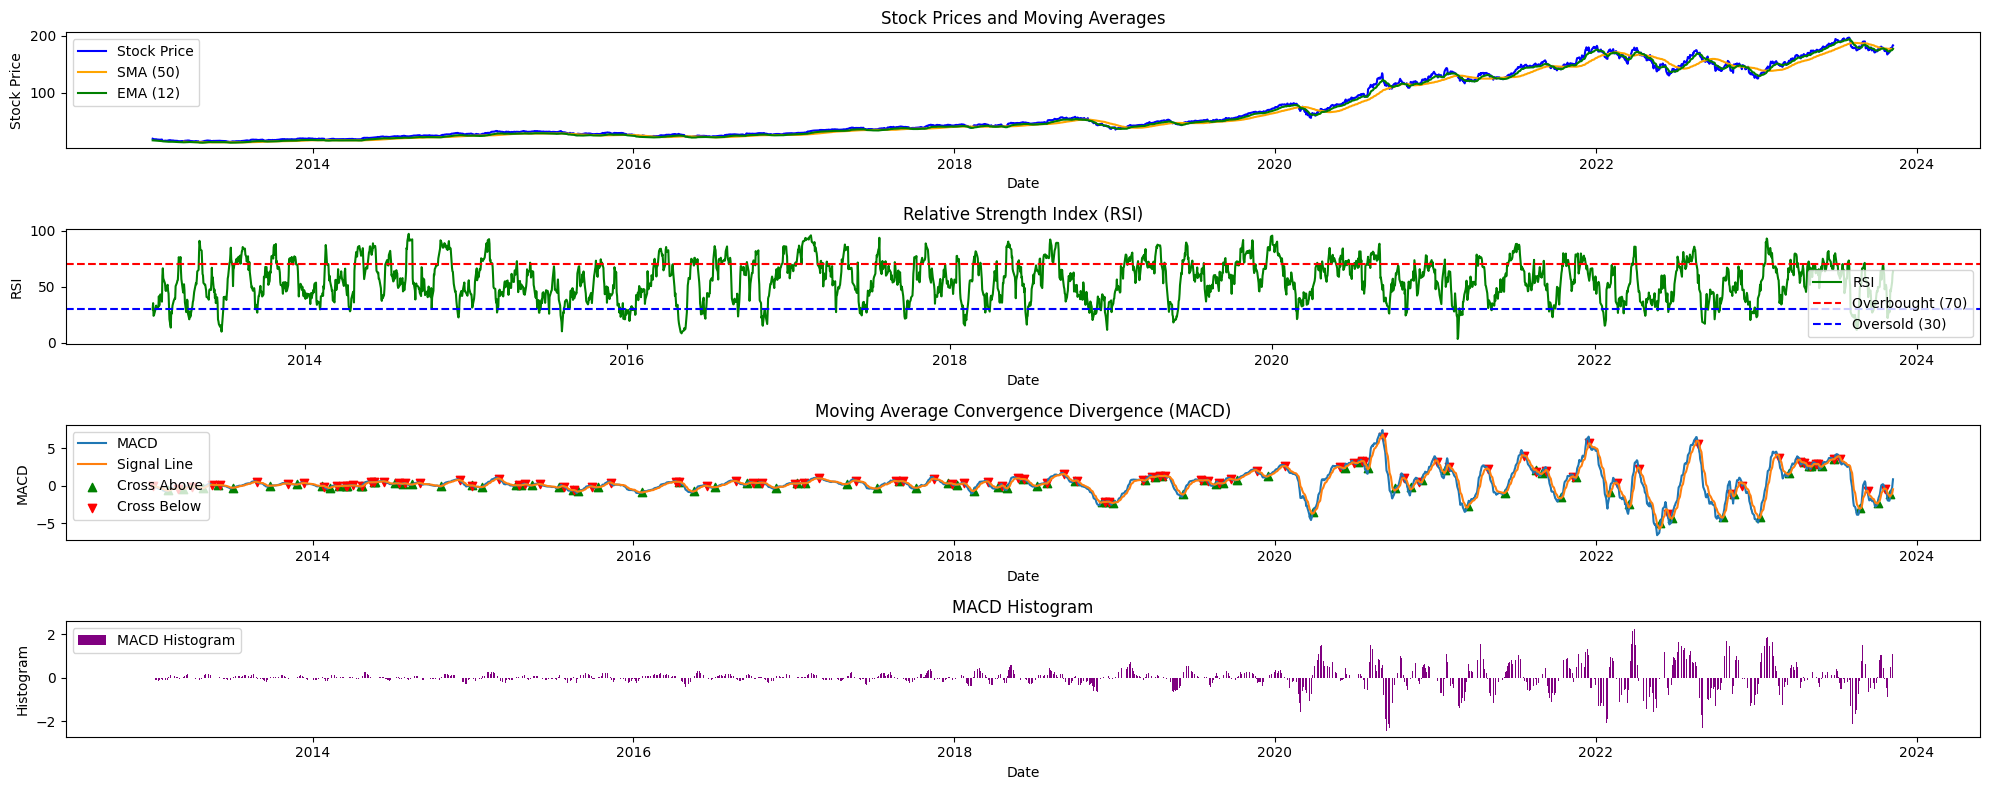

In [239]:
plt.figure(figsize=(20, 8))

# Subplot 1: Stock Prices and Moving Averages
plt.subplot(4, 1, 1)
plt.plot(Sym_data['Date'], Sym_data['Close'], label='Stock Price', color='blue')
plt.plot(Sym_data['Date'], Sym_data['SMA_50'], label='SMA (50)', color='orange')
plt.plot(Sym_data['Date'], Sym_data['EMA_12'], label='EMA (12)', color='green')
plt.title('Stock Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Subplot 2: RSI
plt.subplot(4, 1, 2)
plt.plot(Sym_data['Date'], Sym_data['RSI'], label='RSI', color='green')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='b', linestyle='--', label='Oversold (30)') #GENERALLY 30 and 70 are considered
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()

# Subplot 3: MACD
plt.subplot(4, 1, 3)
plt.plot(Sym_data['Date'], Sym_data['MACD'], label='MACD')
plt.plot(Sym_data['Date'], Sym_data['Signal_Line'], label='Signal Line')
# Add markers for crossovers
plt.scatter(Sym_data.loc[cross_above, 'Date'], Sym_data.loc[cross_above, 'MACD'], marker='^', color='g', label='Cross Above')
plt.scatter(Sym_data.loc[cross_below, 'Date'], Sym_data.loc[cross_below, 'MACD'], marker='v', color='r', label='Cross Below')

plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.ylabel('MACD')

plt.legend()
# Plot MACD Histogram
plt.subplot(4, 1, 4)
plt.bar(Sym_data['Date'], Sym_data['MACD'] - Sym_data['Signal_Line'], color='purple', label='MACD Histogram')

plt.title('MACD Histogram')
plt.xlabel('Date')
plt.ylabel('Histogram')
plt.legend()



plt.tight_layout()
plt.show()


Calculating average monthly returns for clearly visible trends.

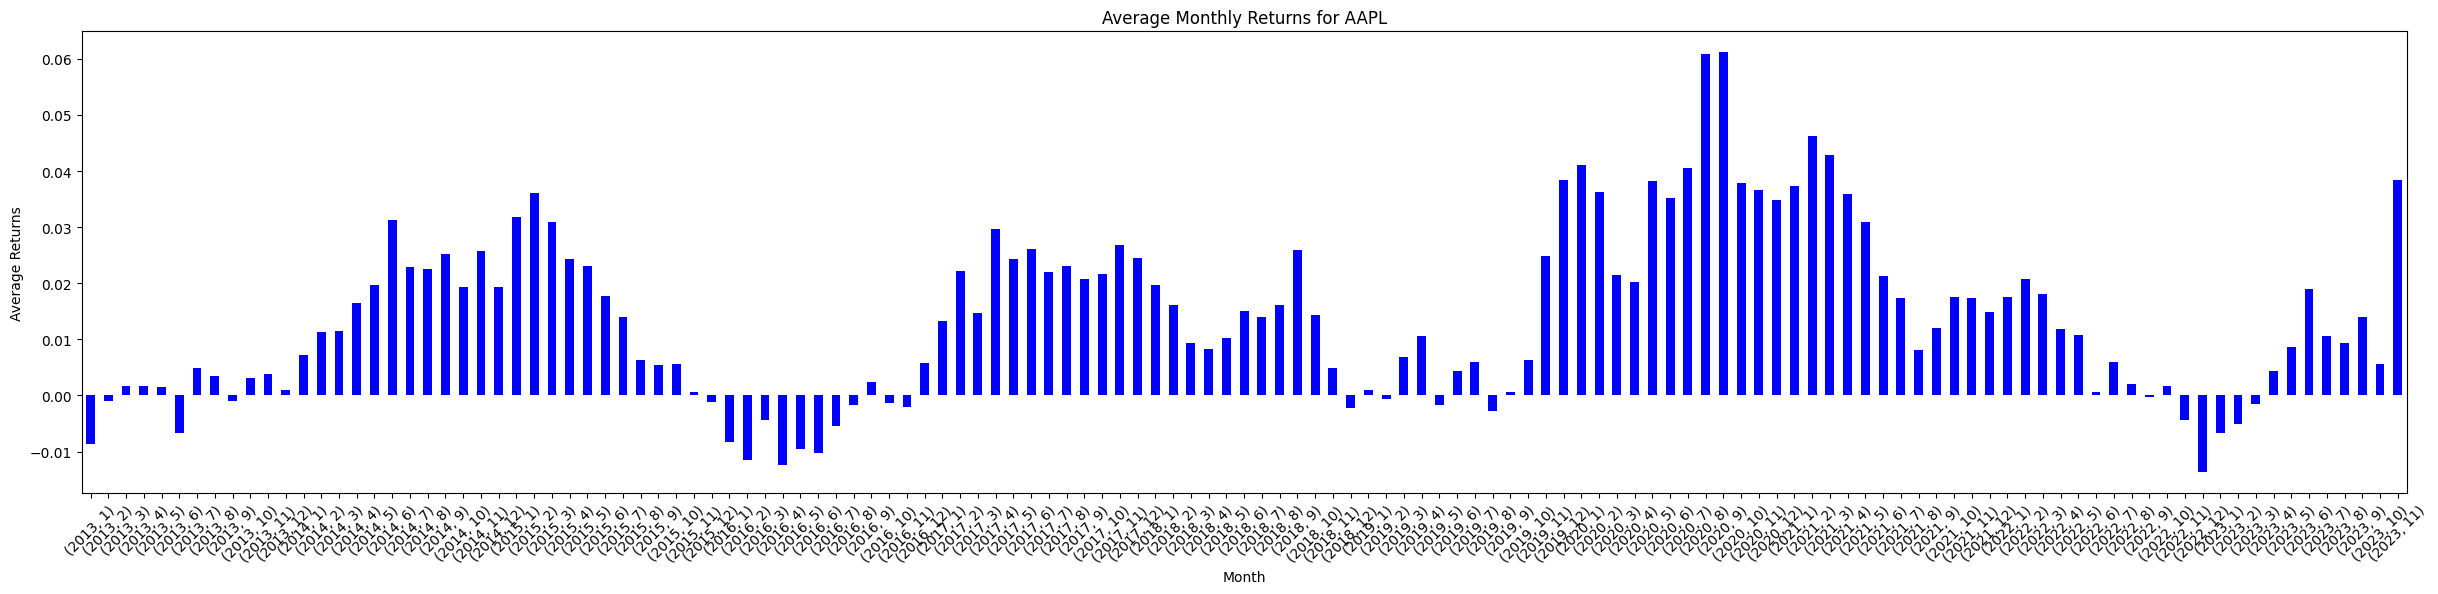

In [238]:
# Convert index to DatetimeIndex
Sym_data1 = Sym_data.set_index('Date')
# Extract Month and Day from the Date
Sym_data1['Year'] = Sym_data1.index.year
Sym_data1['Month'] = Sym_data1.index.month
Sym_data1['Day'] = Sym_data1.index.day
# Calculate Average Daily Returns for Each Month
Sym_data1['Daily_Return'] = Sym_data1.groupby(by='Month')[Close].pct_change()
average_returns_by_month = Sym_data1.groupby(['Year', 'Month'])['Daily_Return'].mean()

# Convert the result to a Pandas Series
average_returns_by_month = pd.Series(average_returns_by_month)

# Plotting
plt.figure(figsize=(30, 6))
average_returns_by_month.plot(kind='bar', color='blue')
plt.title('Average Monthly Returns for {}'.format(Sym))
plt.xlabel('Month')
plt.ylabel('Average Returns')
plt.xticks(rotation=45)
plt.show()
